# **Predicción de Corto Plazo para Traiding Swing en Tesla**

### **Introducción**

En el sector financiero, la anticipación de movimientos del mercado es esencial para optimizar decisiones de inversión y maximizar el rendimiento. Este proyecto se centra en la predicción de precios de corto plazo para las acciones de Tesla, Inc., un activo clave en los mercados tecnológicos debido a su alta volatilidad y liquidez.

El análisis busca identificar niveles clave de soporte y resistencia para estructurar estrategias de trading swing que permitan optimizar las entradas, salidas y la gestión de riesgos en operaciones bursátiles. Este enfoque se basa en la integración de datos históricos y herramientas de análisis técnico, con el propósito de sustentar decisiones informadas y estratégicas.

### **Objetivos del Proyecto**
- **Predicción de precios:** Estimar los precios máximos, mínimos y de cierre de las acciones de Tesla en un horizonte de 4 días hábiles (resto de la semana), con un alto nivel de precisión.
- **Identificación de niveles clave:** Calcular niveles dinámicos de soporte y resistencia basados en los datos históricos y predicciones de precios.
- **Optimización de estrategias de trading:** Diseñar estrategias de entrada, salida y gestión de riesgos en operaciones swing.

### **Metodología**
El desarrollo del proyecto seguirá las siguientes etapas:
1. Configuración de Herramientas y Recursos
2. Recolección y Limpieza de Datos
3. Análisis de Tendencias y Niveles Históricos
4. Proyección de Precios
5. Definición de Niveles Clave
6. Estrategias de Trading Swing
7. Conclusiones

-------

# Paso 1: Configuración de Herramientas y Recursos

Cargar las librerías necesarias y realizar las configuraciones iniciales

In [5]:
import yfinance as yf
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.stattools import adfuller
from sklearn.metrics import mean_squared_error, mean_absolute_error

import warnings

# Ajustar configuraciones
plt.style.use('ggplot') 
sns.set_theme()
warnings.filterwarnings('ignore')

------------

# Paso 2: Recolección y Limpieza de Datos

Obtener los datos históricos de tesla, procesarlos, organizarlos y limpiarlos

In [9]:
# Extracción de precios históricos de tesla a partir del 1 de diciembre del 2022 (captura mejor la situacion actual de tesla)
tesla = yf.download(tickers = 'tsla', start = '2022-12-01', end = '2025-01-07', rounding = True)

# Eliminar la columna Adj Close
tesla = tesla.drop(columns=['Adj Close', 'Open', 'Volume'])

# Eliminar datos nulos
tesla = tesla.dropna()

tesla.tail()

[*********************100%***********************]  1 of 1 completed


,High,Low,Close
Date,,,
2024-12-30,427.00,415.75,417.41
2024-12-31,427.93,402.54,403.84
2025-01-02,392.73,373.04,379.28
2025-01-03,411.88,379.45,410.44
2025-01-06,426.43,401.70,411.05


--------

# Paso 3: Análisis de Tendencias y Niveles Históricos

Análisis de los datos y predicción de precios máximos, mínimos y de cierre para los próximos 4 días hábiles

### Paso 3.1: Separar los datos high, low y close en diferentes df para entrenar independientemente los modelos

In [14]:
# Datos de máximos intradiarios
high_data = pd.DataFrame(tesla['High'])
high_data.index = pd.to_datetime(high_data.index)

# Datos de mínimos intradiarios
low_data = pd.DataFrame(tesla['Low'])
low_data.index = pd.to_datetime(low_data.index)

# Datos de cierre
close_data = pd.DataFrame(tesla['Close'])
close_data.index = pd.to_datetime(close_data.index)

### Paso 3.2: Identificar p, d, q, para nuestros modelos ARIMA

In [17]:
# Realizar la prueba de dickey-fuller para cada df
result_high = adfuller(high_data['High'])
result_low = adfuller(low_data['Low'])
result_close = adfuller(close_data['Close'])

# Mostrar los resultados
print(f"p-value para high_data: {result_high[1]}")
print(f"p-value para low_data: {result_low[1]}")
print(f"p-value para close_data: {result_close[1]}")

p-value para high_data: 0.7861465482335708
p-value para low_data: 0.6024314281911077
p-value para close_data: 0.9370672020760327


Ningun p-value fue menor a 0.05, por lo cual tendremos que aplicar diferenciación

In [20]:
# Aplicar diferenciacion en cada df
high_data['High Change'] = high_data['High'].diff()
low_data['Low Change'] = low_data['Low'].diff()
close_data['Close Change'] = close_data['Close'].diff()

# Eliminar valores nulos
high_data = high_data.dropna()
low_data = low_data.dropna()
close_data = close_data.dropna()

In [22]:
# Realizar nuevamente la prueba de dickey-fuller para cada df
result_high = adfuller(high_data['High Change'])
result_low = adfuller(low_data['Low Change'])
result_close = adfuller(close_data['Close Change'])

# Mostrar los resultados
print(f"p-value para high_data: {result_high[1]}")
print(f"p-value para low_data: {result_low[1]}")
print(f"p-value para close_data: {result_close[1]}")

p-value para high_data: 2.683431108676738e-07
p-value para low_data: 3.84270382856578e-08
p-value para close_data: 0.0


El p-value fue menor a 0.05 para todos los casos, por lo cual podemos definir d = 1 para todos

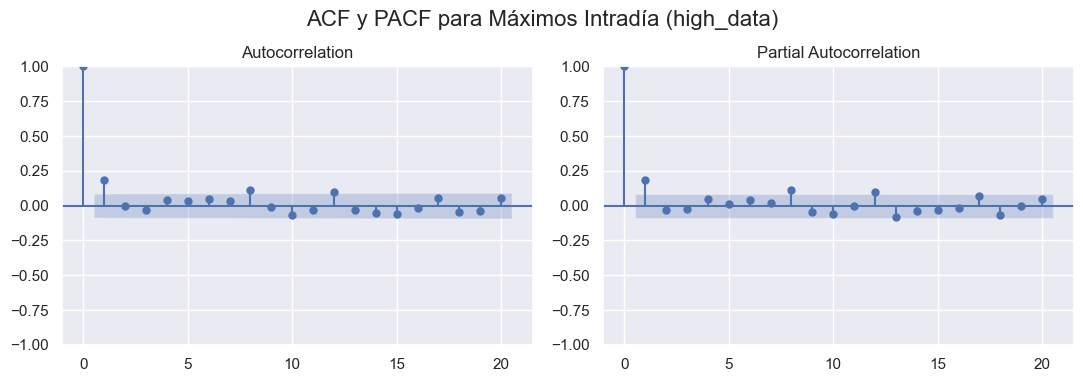

In [25]:
# Graficar ACF y PACF para high_data
fig, axes = plt.subplots(1, 2, figsize = (11, 4))

# Graficar ACF
plot_acf(high_data['High Change'], lags = 20, ax = axes[0], alpha = 0.05)

# Graficar PACF
plot_pacf(high_data['High Change'], lags = 20, ax = axes[1], alpha = 0.05)

# Ajustar diseño
plt.suptitle("ACF y PACF para Máximos Intradía (high_data)", fontsize = 16, y = 0.95)
plt.tight_layout()

plt.show()

Se puede observar una caída pronunciada a 0 después del lag 1 (que sale del intervalo de confianza) en ambos casos, por lo cual p, q = 1

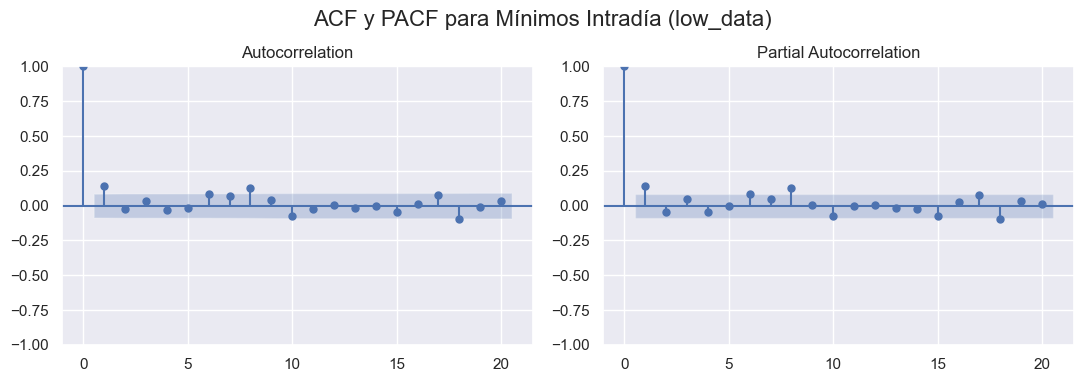

In [28]:
# Graficar ACF y PACF para low_data
fig, axes = plt.subplots(1, 2, figsize = (11, 4))

# Graficar ACF
axes[0].set_title("ACF - Mínimos Intradía (low_data)")
plot_acf(low_data['Low Change'], lags = 20, ax = axes[0], alpha = 0.05)

# Graficar PACF
axes[1].set_title("PACF - Mínimos Intradía (low_data)")
plot_pacf(low_data['Low Change'], lags = 20, ax = axes[1], alpha = 0.05)

# Ajustar diseño
plt.suptitle("ACF y PACF para Mínimos Intradía (low_data)", fontsize = 16, y = 0.95)
plt.tight_layout()

plt.show()

Nuevamente se observa esa caída pronunciada después del lag 1 en ambos casos, nuevamente, p, q = 1

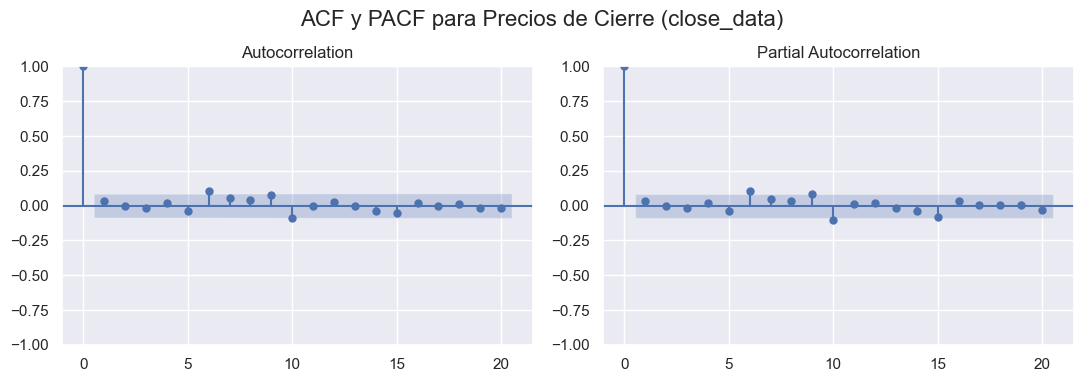

In [31]:
# Graficar ACF y PACF para close_data
fig, axes = plt.subplots(1, 2, figsize = (11, 4))

# Graficar ACF
axes[0].set_title("ACF - Precios de Cierre (close_data)")
plot_acf(close_data['Close Change'], lags = 20, ax = axes[0], alpha = 0.05)

# Graficar PACF
axes[1].set_title("PACF - Precios de Cierre (close_data)")
plot_pacf(close_data['Close Change'], lags = 20, ax = axes[1], alpha = 0.05)

# Ajustar diseño
plt.suptitle("ACF y PACF para Precios de Cierre (close_data)", fontsize = 16, y = 0.95)
plt.tight_layout()

plt.show()

En este caso ninguno de los primeros lags (lags significativos) sale notoriamente del intervalo de confianza en ninguno de los dos casos, por lo cual, p, q = 0

Conclusión:
- Para high_data el mejor modelo parece ser un ARIMA(1, 1, 1)
- Para low_data el mejor modelo parece ser un ARIMA(1, 1, 1)
- Para close_data el mejor modelo parece ser un ARIMA(0, 1, 0)

### Paso 3.3: Ajustar los modelos ARIMA

In [36]:
# Ajustar el modelo ARIMA con los valores identificados para cada df (high, low, close)
model_high = ARIMA(high_data['High'], order = (1, 1, 1))
model_low = ARIMA(low_data['Low'], order = (1, 1, 1))
model_close = ARIMA(close_data['Close'], order = (0, 1, 0))

# Entrenar los modelos
model_high_fit = model_high.fit()
model_low_fit = model_low.fit()
model_close_fit = model_close.fit()

### Paso 3.4: Validar los modelos

In [39]:
# Función para graficar los residuos de los modelos
def graph_residue(model):
    # Residuos del modelo
    residuals = model.resid
    
    fig, axes = plt.subplots(1, 2, figsize = (14, 4))
    
    # Graficar los residuos
    axes[0].plot(residuals)
    axes[0].set_title(f'Residuos del modelo ARIMA')
    
    # Graficación de la función de autocorrelación parcial PACF
    plot_pacf(residuals, ax = axes[1], alpha = 0.05)
    axes[1].set_title(f'PACF de los residuos')
    
    plt.tight_layout()
    
    plt.show()

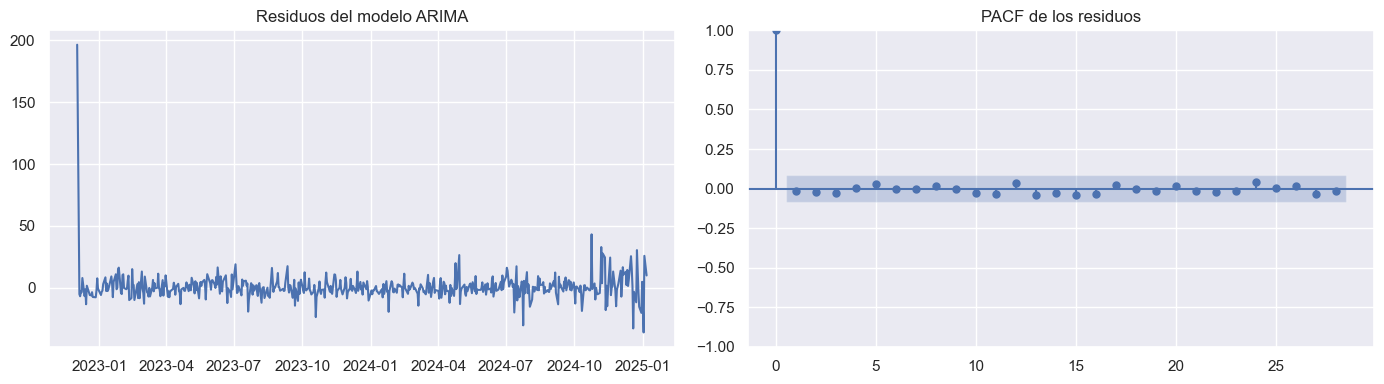

In [41]:
# Residuos del modelo high
graph_residue(model_high_fit)

El gráfico de los residuos en el tiempo no parece tener patrones claros, lo que es un buen indicativo, ya que parece que el modelo está capturando correctamente la dinámica de la serie.

Por otro lado el grafico PACF muestra que no hay residuos fuera del intervalo de confianza, esto indica que no hay correlaciones parciales significativas en los residuos, por lo tanto sugiere que el modelo a capturado adecuadamente las relaciones autoregresivas de la serie.

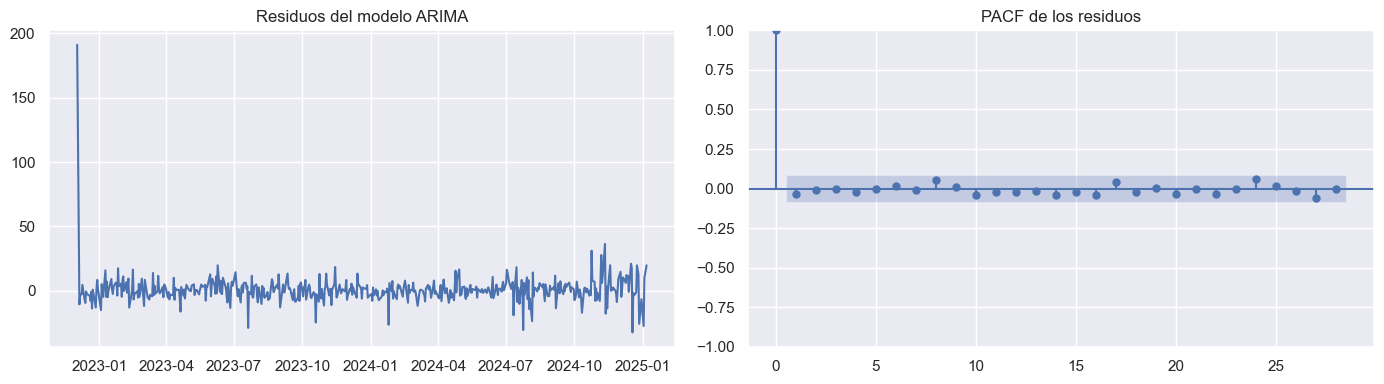

In [44]:
# Residuos del modelo low
graph_residue(model_low_fit)

Nuevamente no se observan patrones claros en el primer gráfico, por lo tanto podemos concluir que el modelo está capturando correctamente la dinámica de la serie.

De igual forma, el segundo gráfico muestra que no hay residuos fuera del intervalo de confianza, esto es un buen indicativo y sugiere que el modelo captura adecuadamente las relaciones autoregresivas de la serie.

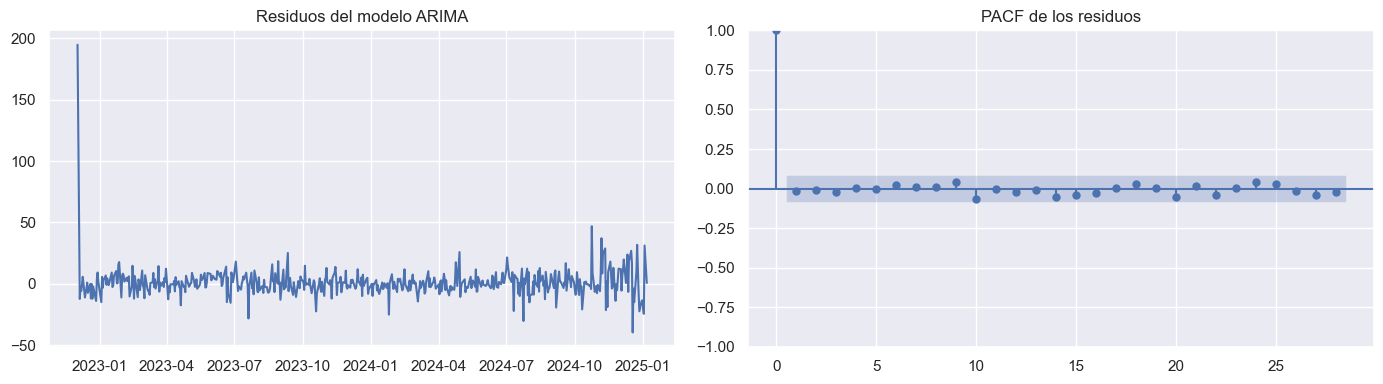

In [47]:
# Residuos del modelo close
graph_residue(model_close_fit)

Finalmente nos encontramos con el mismo escenario para el modelo close, lo cual indica que el modelo captura correctamente la dinámica de la serie y es capaz de capturar bien las relaciones autoregresivas de la misma.

In [50]:
# Definir función para realizar predicciones dentro de la muestra y calcular métricas
def graph_in_sample_preds(model, data):
    # Predicciones dentro de la muestra
    in_sample_preds = model.predict(start = data.index[0], end = data.index[-1], typ = 'levels')
    
    # Convertir a array para facilitar cálculos
    in_sample_preds = in_sample_preds[1:]
    true_values = data[data.columns[0]].values[1:]
    
    # Cálculo de métricas
    rmse = np.sqrt(mean_squared_error(true_values, in_sample_preds))
    mae = mean_absolute_error(true_values, in_sample_preds)
    mape = np.mean(np.abs((true_values - in_sample_preds) / true_values)) * 100
    
    # Graficar datos reales vs las predicciones dentro de la muestra
    plt.figure(figsize = (10, 6))
    plt.plot(data[data.columns[0]], label = "Datos reales", color = "blue")
    plt.plot(data.index[1:], in_sample_preds, label = "Predicciones dentro de la muestra", linestyle = "--", color = "orange")
    plt.legend()
    plt.title(f"Predicciones dentro de la muestra\nRMSE = {rmse:.2f}, MAE = {mae:.2f}, MAPE = {mape:.2f}%")
    plt.show()
    
    return

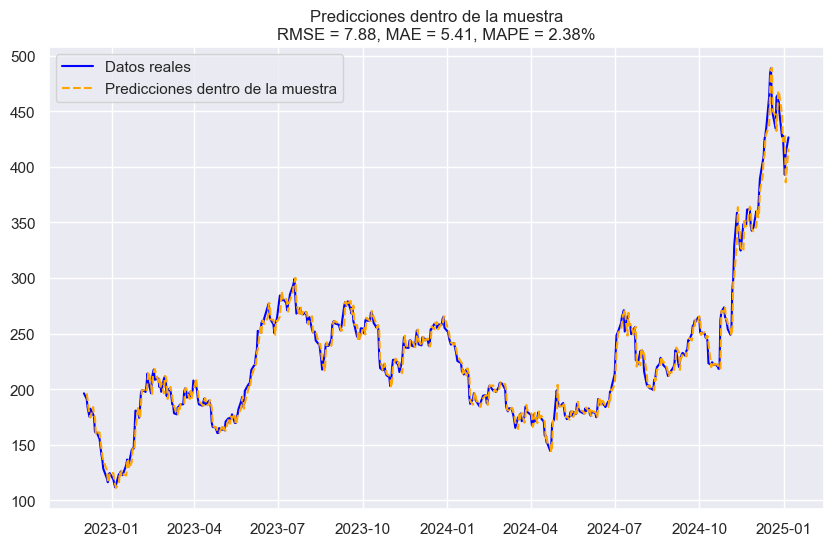

In [52]:
# Graficar las predicciones dentro de la muestra para high
graph_in_sample_preds(model_high_fit, high_data)

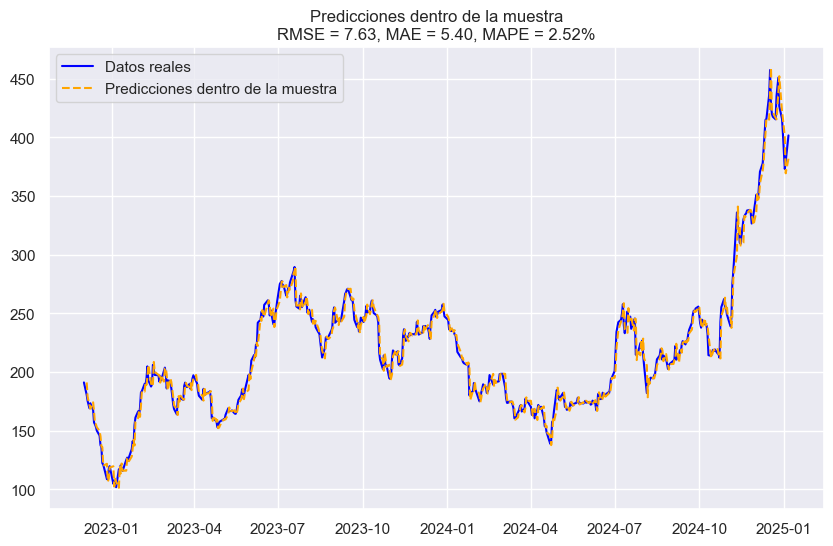

In [54]:
# Graficar las predicciones dentro de la muestra para low
graph_in_sample_preds(model_low_fit, low_data)

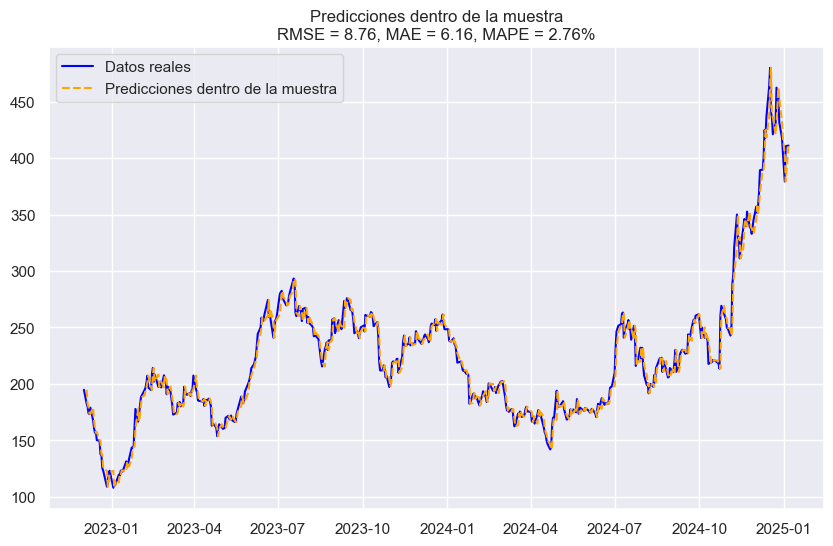

In [56]:
# Graficar las predicciones dentro de la muestra para close
graph_in_sample_preds(model_close_fit, close_data)

Como se observa en las gráficas, los modelos capturan de buena manera la dinámica histórica de las series.

Para todos los modelos, MAPE es sumamente bajo, lo que indica que los modelos ajustan muy bien los datos reales y que los errores relativos son pequeños

Por otro lado, de igual forma en todos los modelos RMSE y MAE son cercanos y están en un rango aceptable, lo que significa que los errores grandes no dominan el ajuste de ningún modelo.

--------

# Paso 4: Proyección de Precios

Predecir precios máximos y mínimos intradía, asi como precio de cierre para los próximos 4 días

In [181]:
# función para obtener predicciones e intervalos de confianza
def get_forecast_df(model_fit, data, type, period, a):
    forecast = model_fit.get_forecast(steps = period)
    predictions = forecast.predicted_mean
    confidence_intervals = forecast.conf_int(alpha = a)
    
    forecast_df = pd.DataFrame({
        'Date': pd.date_range(start = data.index[-1] + pd.Timedelta(days = 1), periods = period, freq = 'D'),
        f'{type} Pred': predictions.values.round(2),
        f'{type} Min': confidence_intervals.iloc[:, 0].values.round(2),
        f'{type} Max': confidence_intervals.iloc[:, 1].values.round(2)
    })

    # Establecer la columna 'Date' como índice
    forecast_df.set_index('Date', inplace=True)

    # Mostrar solo las columnas de interés
    forecast_df = forecast_df[[f'{type} Pred', f'{type} Min', f'{type} Max']]
    
    return forecast_df

In [183]:
# Predicción e intervalo de confianza para máximos intradía
high_forecast = get_forecast_df(model_high_fit, high_data, 'High', 4, 0.5)
high_forecast

,High Pred,High Min,High Max
Date,,,
2025-01-07,428.65,423.33,433.97
2025-01-08,428.80,420.54,437.07
2025-01-09,428.81,418.36,439.26
2025-01-10,428.81,416.56,441.07


In [185]:
# Predicción e intervalo de confianza para mínimos intradía
low_forecast = get_forecast_df(model_low_fit, low_data, 'Low', 4, 0.5)
low_forecast

,Low Pred,Low Min,Low Max
Date,,,
2025-01-07,404.03,398.88,409.18
2025-01-08,403.40,395.54,411.26
2025-01-09,403.57,393.85,413.29
2025-01-10,403.52,392.22,414.83


In [193]:
# Predicción e intervalos de confianza para el precio de cierre
close_forecast = get_forecast_df(model_close_fit, close_data, 'Close', 4, 0.5)
close_forecast

,Close Pred,Close Min,Close Max
Date,,,
2025-01-07,411.05,405.14,416.96
2025-01-08,411.05,402.70,419.40
2025-01-09,411.05,400.82,421.28
2025-01-10,411.05,399.24,422.86


-----

# Paso 5: Definición de niveles clave

Definir los niveles de soporte y resistencia (para diferentes situaciones), puntos pivote, etc.

### Paso 5.1: Graficar predicciones e intervalos

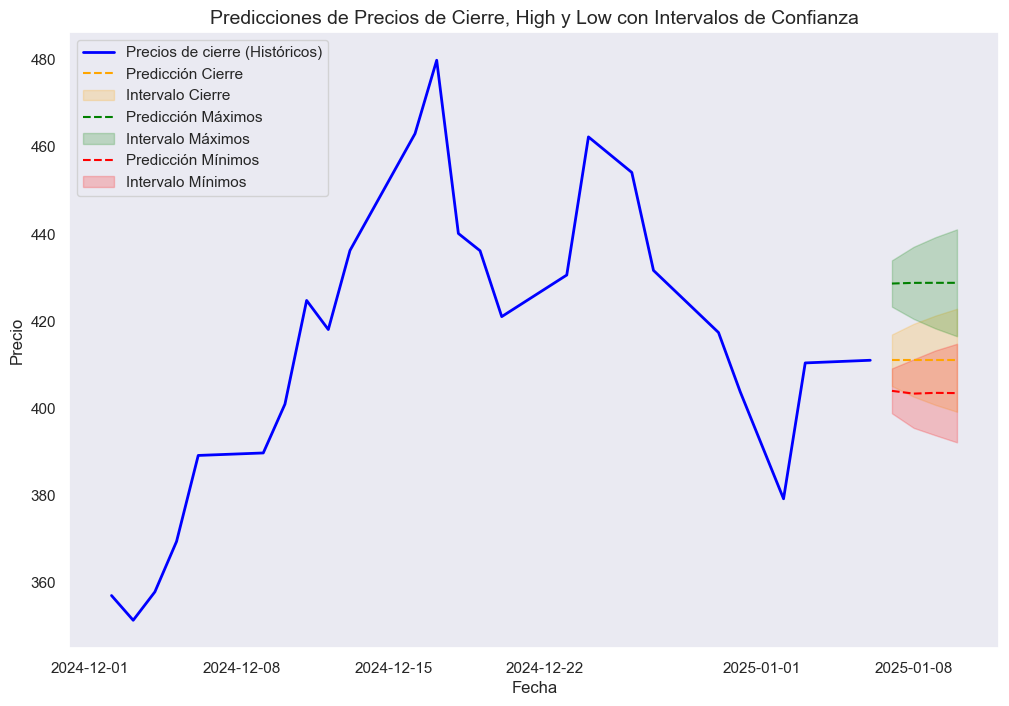

In [197]:
# Gráfico de precios de cierre y predicciones con intervalos de confianza
plt.figure(figsize = (12, 8))

# Graficar precios de cierre históricos
plt.plot(close_data['Close']['2024-12-01':], label = "Precios de cierre (Históricos)", color = "blue", linewidth = 2)

# Graficar predicción de cierre y su intervalo
plt.plot(close_forecast.index, close_forecast["Close Pred"], label = "Predicción Cierre", linestyle = "--", color = "orange")
plt.fill_between(
    close_forecast.index,
    close_forecast["Close Min"],
    close_forecast["Close Max"],
    color = "orange", alpha = 0.2, label = "Intervalo Cierre"
)

# Graficar predicción de high y su intervalo
plt.plot(high_forecast.index, high_forecast["High Pred"], label = "Predicción Máximos", linestyle = "--", color = "green")
plt.fill_between(
    high_forecast.index,
    high_forecast["High Min"],
    high_forecast["High Max"],
    color = "green", alpha = 0.2, label = "Intervalo Máximos"
)

# Graficar predicción de low y su intervalo
plt.plot(low_forecast.index, low_forecast["Low Pred"], label = "Predicción Mínimos", linestyle = "--", color = "red")
plt.fill_between(
    low_forecast.index,
    low_forecast["Low Min"],
    low_forecast["Low Max"],
    color = "red", alpha = 0.2, label = "Intervalo Mínimos"
)

# Personalización del gráfico
plt.title("Predicciones de Precios de Cierre, High y Low con Intervalos de Confianza", fontsize = 14)
plt.xlabel("Fecha", fontsize = 12)
plt.ylabel("Precio", fontsize = 12)
plt.legend(loc = 'upper left')
plt.grid()
plt.show()

Conclusiones:

- El mercado parece estar en un estado neutral a ligeramente bajista
- El hecho de que los intervalos se abran tanto puede significar que hay cierta incertidumbre

### Paso 5.2: Calcular soportes, resistencias y puntos pivote

In [278]:
# Crear un df para almacenar soporte, resistencia, pivote y sus intervalos
levels_df = pd.DataFrame(index = close_forecast.index)

# Cálculo del pivote
levels_df["Pivote"] = ((high_forecast["High Pred"] + low_forecast["Low Pred"] + close_forecast["Close Pred"]) / 3).round(3)
levels_df["Pivote Min"] = ((high_forecast["High Min"] + low_forecast["Low Min"] + close_forecast["Close Min"]) / 3).round(3)
levels_df["Pivote Max"] = ((high_forecast["High Max"] + low_forecast["Low Max"] + close_forecast["Close Max"]) / 3).round(3)

# Primer nivel de resistencia (R1) y soporte (S1)
levels_df["Resistencia 1 (R1)"] = ((2 * levels_df["Pivote"]) - low_forecast["Low Pred"]).round(3)
levels_df["R1 Min"] = ((2 * levels_df["Pivote Min"]) - low_forecast["Low Min"]).round(2)
levels_df["R1 Max"] = ((2 * levels_df["Pivote Max"]) - low_forecast["Low Max"]).round(3)

levels_df["Soporte 1 (S1)"] = ((2 * levels_df["Pivote"]) - high_forecast["High Pred"]).round(3)
levels_df["S1 Min"] = ((2 * levels_df["Pivote"]) - high_forecast["High Max"]).round(3)
levels_df["S1 Max"] = ((2 * levels_df["Pivote"]) - high_forecast["High Min"]).round(3)

# Segundo nivel de Resistencia (R2) y Soporte (S2) con intervalos
levels_df["Resistencia 2 (R2)"] = (levels_df["Pivote"] + (high_forecast["High Pred"] - low_forecast["Low Pred"])).round(3)
levels_df["R2 Min"] = (levels_df["Pivote Min"] + (high_forecast["High Min"] - low_forecast["Low Min"])).round(3)
levels_df["R2 Max"] = (levels_df["Pivote Max"] + (high_forecast["High Max"] - low_forecast["Low Max"])).round(3)

levels_df["Soporte 2 (S2)"] = (levels_df["Pivote"] - (high_forecast["High Pred"] - low_forecast["Low Pred"])).round(3)
levels_df["S2 Min"] = (levels_df["Pivote Min"] - (high_forecast["High Max"] - low_forecast["Low Max"])).round(3)
levels_df["S2 Max"] = (levels_df["Pivote Max"] - (high_forecast["High Min"] - low_forecast["Low Min"])).round(3)

# Mostrar el DataFrame resultante
levels_df

,Pivote,Pivote Min,Pivote Max,Resistencia 1 (R1),R1 Min,R1 Max,Soporte 1 (S1),S1 Min,S1 Max,Resistencia 2 (R2),R2 Min,R2 Max,Soporte 2 (S2),S2 Min,S2 Max
Date,,,,,,,,,,,,,,,
2025-01-07,414.577,409.117,420.037,425.124,419.35,430.894,400.504,395.184,405.824,439.197,433.567,444.827,389.957,384.327,395.587
2025-01-08,414.417,406.260,422.577,425.434,416.98,433.894,400.034,391.764,408.294,439.817,431.260,448.387,389.017,380.450,397.577
2025-01-09,414.477,404.343,424.610,425.384,414.84,435.930,400.144,389.694,410.594,439.717,428.853,450.580,389.237,378.373,400.100
2025-01-10,414.460,402.673,426.253,425.400,413.13,437.676,400.110,387.850,412.360,439.750,427.013,452.493,389.170,376.433,401.913


### Paso 5.3: Graficar soportes, resistencias, intervalos, predicciones, etc, para sacar conclusiones

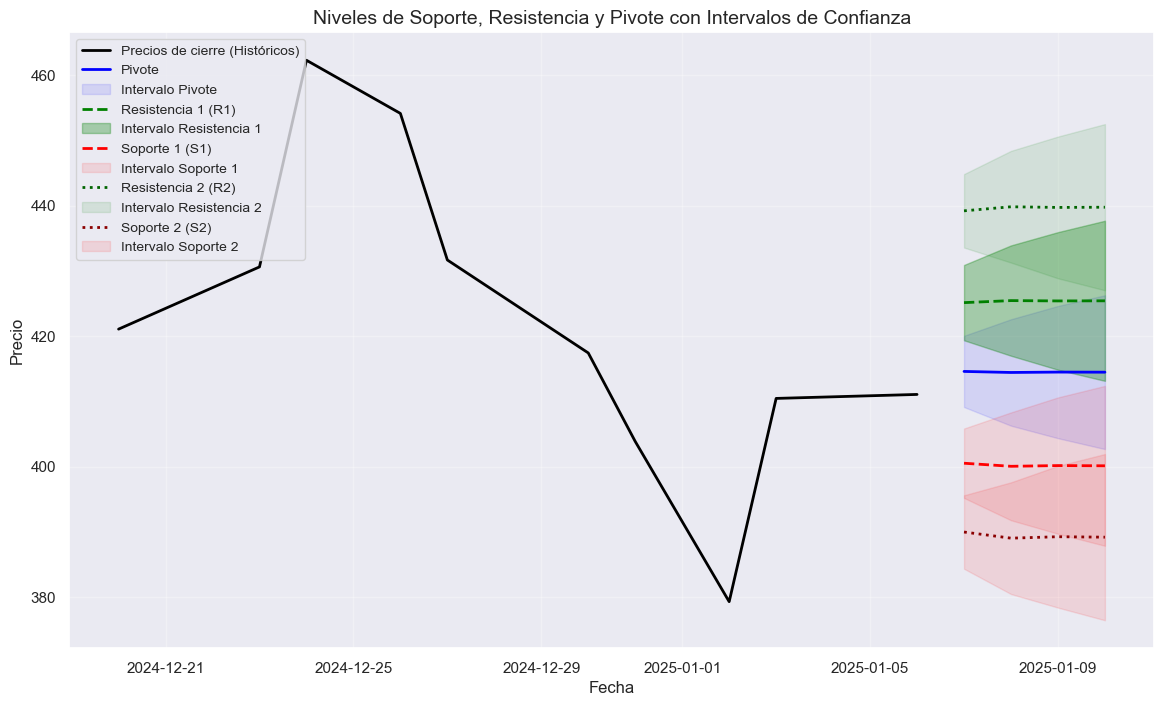

In [281]:
plt.figure(figsize = (14, 8))

# Graficar precios de cierre históricos
plt.plot(close_data['Close']['2024-12-20':], label = "Precios de cierre (Históricos)", color = "black", linewidth = 2)

# Graficar el pivote y su intervalo
plt.plot(levels_df.index, levels_df["Pivote"], label = "Pivote", color = "blue", linestyle = "-", linewidth = 2)
plt.fill_between(levels_df.index, levels_df["Pivote Min"], levels_df["Pivote Max"], color = "blue", alpha = 0.1, label = "Intervalo Pivote")

# Graficar resistencia 1 y su intervalo
plt.plot(levels_df.index, levels_df["Resistencia 1 (R1)"], label = "Resistencia 1 (R1)", color = "green", linestyle = "--", linewidth = 2)
plt.fill_between(levels_df.index, levels_df["R1 Min"], levels_df["R1 Max"], color = "green", alpha = 0.3, label = "Intervalo Resistencia 1")

# Graficar soporte 1 y su intervalo
plt.plot(levels_df.index, levels_df["Soporte 1 (S1)"], label = "Soporte 1 (S1)", color = "red", linestyle = "--", linewidth = 2)
plt.fill_between(levels_df.index, levels_df["S1 Min"], levels_df["S1 Max"], color = "red", alpha = 0.1, label = "Intervalo Soporte 1")

# Graficar resistencia 2 y su intervalo
plt.plot(levels_df.index, levels_df["Resistencia 2 (R2)"], label = "Resistencia 2 (R2)", color = "darkgreen", linestyle = ":", linewidth = 2)
plt.fill_between(levels_df.index, levels_df["R2 Min"], levels_df["R2 Max"], color = "green", alpha = 0.1, label = "Intervalo Resistencia 2")

# Graficar soporte 2 y su intervalo
plt.plot(levels_df.index, levels_df["Soporte 2 (S2)"], label = "Soporte 2 (S2)", color = "darkred", linestyle = ":", linewidth = 2)
plt.fill_between(levels_df.index, levels_df["S2 Min"], levels_df["S2 Max"], color = "red", alpha = 0.1, label = "Intervalo Soporte 2")

# Configuración de la gráfica
plt.title("Niveles de Soporte, Resistencia y Pivote con Intervalos de Confianza", fontsize = 14)
plt.xlabel("Fecha", fontsize = 12)
plt.ylabel("Precio", fontsize = 12)
plt.legend(loc = "upper left", fontsize = 10)
plt.grid(alpha = 0.3)
plt.show()

Como se puede apreciar en la figura, las zonas de soporte y resistencia están perfectamente marcadas, por lo cual, podemos proceder a realizar la estrategia de trading swing

------

# **Paso 6: Estrategias de Trading Swing**

Basándonos en los niveles (Pivote, S1, R1, S2, R2) y sus respectivos intervalos de confianza, se desarrollará una estrategia de trading swing para escenarios alcistas, bajistas y neutrales, esta estrategia busca maximizar las oportunidades de entrada y salida con base en el comportamiento esperado del precio alrededor de los niveles clave.

#### 1. **Principios Generales**
   - **Pivote:** Punto de equlibrio. Se usará como guía inicial para identificar la tendencia (por encima = alcista, por debajo = bajista).
   - **Intervalos de confianza:** Se usarán para ajustar las decisiones y detectar posibles rupturas o fallas en los niveles.

#### 2. **Escenarios y Decisiones** 
   - **Escenario Alcista:**
        1. Condición Inicial:
            - El precio está por encima del pivote:
                - 7 de Enero: 414.58
                - 8 de Enero: 414.42
                - 9 de Enero: 414.48
                - 10 de Enero: 414.46
        2. Entradas (compra):
            - Entrada principal (cuando el precio rebota serca de S1):
                - 7 de Enero: 400.50
                - 8 de Enero: 400.03
                - 9 de Enero: 400.14
                - 10 de Enero: 400.11
            - Entrada agresiva (si el precio rompe claramente R1 Max):
                - 7 de enero: 430.89
                - 8 de enero: 433.89
                - 9 de enero: 435.93
                - 10 de enero: 437.68
        3. Salidas (venta):
            - Salida conservadora (al alcanzar R1):
                - 7 de enero: 425.12
                - 8 de enero: 425.43
                - 9 de enero: 425.38
                - 10 de enero: 425.40
            - Salida extendida (si el precio rompe R1 max, mantener hasta R2):
                - 7 de enero: 439.197
                - 8 de enero: 439.817
                - 9 de enero: 439.717
                - 10 de enero: 439.750
        4. Gestión de Riesgo:
            - Stop-Loss (justo por debajo del soporte S1 Min):
                - 7 de enero: 395.18
                - 8 de enero: 391.76
                - 9 de enero: 389.69
                - 10 de enero: 387.85
######
   - **Escenario Bajista**
        1. Condición Inicial:
            - El precio está por debajo del pivote:
                - 7 de enero: 414.58
                - 8 de enero: 414.42
                - 9 de enero: 414.48
                - 10 de enero: 414.46
        2. Entradas (venta en corto):
            - Entrada principal (cuando el precio rebote cerca de R1):
                - 7 de enero: 425.12
                - 8 de enero: 425.43
                - 9 de enero: 425.38
                - 10 de enero: 425.40
            - Entrada agresiva (si el precio rompe claramente S1 Min):
                - 7 de enero: 395.18
                - 8 de enero: 391.76
                - 9 de enero: 389.69
                - 10 de enero: 387.85
        3. Salidas (compra para cerrar):
            - Salida conservadora (al alcanzar S1):
                - 7 de Enero: 400.50
                - 8 de Enero: 400.03
                - 9 de Enero: 400.14
                - 10 de Enero: 400.11
            - Salida extendida (si el precio rompe S1 min, mantener hasta S2):
                - 7 de Enero: 389.96
                - 8 de enero: 389.02
                - 9 de enero: 389.24
                - 10 de enero: 389.17
        4. Gestión de Riesgo:
            - Stop-Loss (justo por encima de R1 Max):
                - 7 de enero: 430.894
                - 8 de enero: 433.894
                - 9 de enero: 435.930
                - 10 de enero: 437.676
######
   - **Escenario Neutral**
        1. Condición Inicial:
            - El precio oscila entre el pivote y los niveles S1 y R1:
                - 7 de enero: 414.58 (400.50 - 425.12)
                - 8 de enero: 414.42 (400.03 - 425.43)
                - 9 de enero: 414.48 (400.14 - 425.38)
                - 10 de enero: 414.46 (400.11 - 425.40)
        2. Entradas (compra/venta):
            - Comprar:
                - En rebotes cerca de S1, con objetivo en el pivote o R1
            - Vender:
                - En rebotes cerca de R1, con objetivo en el pivote o S1 
        3. Salidas:
            - Al alcanzar el nivel opuesto (R1 o S1)
            - Si hay rompimiento fuera del intervalo 
        4. Gestión de Riesgo:
            - Stop-Loss:
                - Por fuera el intervalo del nivel opuesto

--------

# Paso 7: Conclusiones

#### **Resumen del Proyecto:**
- Se desarrolló una estrategia de trading swing basada en modelos ARIMA para predecir los niveles de soporte, resistencia y pivote, incorporando intervalos de confianza calculados para el precio de cierre, máximo y mínimo intradiario.
- Los resultados obtenidos proporcionaron niveles específicos de precios útiles para escenarios alcistas, bajistas y neutrales, ajustados para minimizar riesgos y maximizar oportunidades de trading.

#### **Hallazgos Clave:**
1. **Efectividad de los Modelos ARIMA**:
   - Los modelos ARIMA se mostraron confiables en la predicción de precios futuros dentro de un rango de confianza razonable (90% combinado).
   - La inclusión de predicciones separadas para el cierre, máximos y mínimos intradiarios permitió una representación más completa de los posibles movimientos del mercado.

3. **Niveles Calculados**:
   - Los niveles de soporte, resistencia y pivote resultaron alineados con el comportamiento esperado del mercado.
   - Los intervalos ajustados a un nivel de confianza intermedio proporcionaron mayor precisión en escenarios extremos, evitando rangos excesivamente amplios.

4. **Escenarios de Trading**:
   - Se definieron reglas claras para operaciones en mercados alcistas, bajistas y neutrales.
   - La estrategia incorpora flexibilidad para adaptarse a cambios inesperados del mercado.

#### **Conclusión Final:**
El proyecto logró desarrollar una estrategia robusta y bien fundamentada para trading swing utilizando predicciones de precios y niveles clave del mercado. Los resultados obtenidos representan una base sólida para su aplicación en entornos profesionales y futuros desarrollos.

-------

Proyecto realizado por: Alejandro López Valdivia

Realizado el: 7 de enero del 2025